In [23]:
from dptb.postprocess.topybinding import ToPybinding
from dptb.data.build import build_dataset
from dptb.data import AtomicData
from dptb.nn import build_model
import numpy as np
from ase.io import read
import pybinding as pb
from dptb.utils.tools import j_loader
from dptb.postprocess.bandstructure.band import Band
import matplotlib.pyplot as plt

In [13]:
model = build_model(checkpoint="../hBN_dftb/nnsk/checkpoint/nnsk.best.pth")
model.eval()
AtomicData_options = {"r_max": 5.0,"er_max": 3.5, "oer_max":1.6, "pbc": True}
stru_data = "../hBN_dftb/data/struct.vasp"
# 调用from_ase方法，生成一个AtomicData类型数据
dataset = AtomicData.from_ase(
    atoms=read(stru_data),
    **AtomicData_options
    )

In [14]:
tpb = ToPybinding(model=model, device="cpu")
lattice = tpb.get_lattice(dataset)

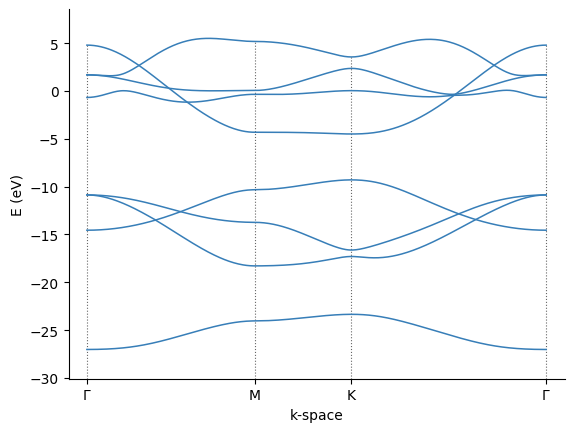

In [16]:
pbmodel = pb.Model(
    lattice,  # predefined lattice from the material repository
    pb.translational_symmetry()    # creates an infinite sheet of graphene
)
solver = pb.solver.lapack(pbmodel)  # eigensolver from the LAPACK library

kpath=[[0, 0, 0],[0.5, 0, 0],[0.3333333, 0.3333333, 0],[0, 0, 0]]
kpath = np.asarray(kpath)
kpath_cat = kpath @ np.array(lattice.reciprocal_vectors())
G = kpath_cat[0]
M = kpath_cat[1]
K = kpath_cat[2]
bands = solver.calc_bands(G,M,K,G)
bands.plot(point_labels=[r'$\Gamma$', 'M', 'K',r'$\Gamma$'])

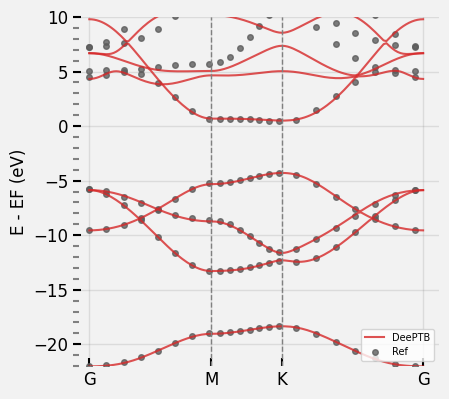

In [22]:
ref_band_file = "../hBN_dftb/data/kpath.0/eigenvalues.npy"
jdata = j_loader("../hBN_dftb/run/band.json")
results_path = "."
kpath_kwargs = jdata["task_options"]
stru_data = "../hBN_dftb/data/struct.vasp"
AtomicData_options = {"r_max": 5.0,"er_max": 3.5, "oer_max":1.6, "pbc": True}

bcal = Band(model=model, 
            use_gui=False, 
            results_path='./', 
            device=model.device)
eigenstatus = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)
bcal.band_plot(ref_band = ref_band_file,
               E_fermi = -5,
               emin = -22,
               emax = 10)


In [42]:
k_path = eigenstatus['klist'] @ np.array(lattice.reciprocal_vectors())
bands = []
for k in k_path:
    solver.set_wave_vector(k)
    bands.append(solver.eigenvalues)
bands = np.asarray(bands)

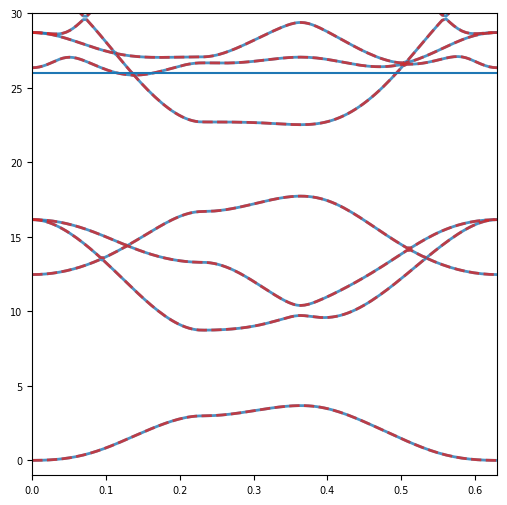

In [50]:
ref_band = np.load(ref_band_file)[0]
nintp=4

eigs =eigenstatus["eigenvalues"]
plt.figure(figsize=(6, 6))
xx = eigenstatus["xlist"]
plt.plot(eigenstatus["xlist"], eigenstatus["eigenvalues"]- np.min(eigenstatus["eigenvalues"]), color="tab:blue", lw=2, alpha=0.8, label="DeePTB")
plt.plot(eigenstatus["xlist"], bands- np.min(bands), '--',color="tab:red", lw=2, alpha=0.8, label="DeePTB")
#plt.plot(eigenstatus["xlist"][::nintp], ref_band[::nintp] - np.min(ref_band), 'ko', ms=4, alpha=0.8, label="Ref")
plt.axhline(26)
plt.ylim(-1,30)
plt.xlim(xx.min(), xx.max())
plt.show()